# ML 512 Project Choice 2 - Explore Dataset(1-3)

## The following is an Implementation of Binary Decision Tree Classifier with cross-validation to detect fraudulent transactions.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

load and shuffle original data

In [15]:
len(df['Class']==1)

284807

In [2]:
# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
df = pd.read_csv("creditcard.csv")
df =  shuffle(df).reset_index(drop=True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,146698.0,1.348232,-1.529678,-0.685076,0.680334,-0.886074,0.263299,-0.292228,0.162271,1.722673,...,-0.158074,-0.842733,0.049524,-0.523975,-0.403743,-0.989577,0.007246,0.005735,308.56,0
1,33072.0,-0.840299,1.016702,0.983929,-1.648990,0.772095,-0.158747,1.048795,-0.625722,0.589914,...,-0.083030,-0.081414,-0.185360,-0.699430,-0.269445,0.710254,-0.946378,-0.378661,2.23,0
2,157180.0,-1.063758,0.113201,-2.634973,-1.065677,-5.844907,2.601784,3.354567,0.370484,-1.412220,...,-0.049377,0.379200,0.853626,-0.428217,-2.306819,-0.774324,0.444321,-0.191635,1042.89,0
3,121636.0,-1.276312,-0.569920,-0.820109,0.050616,0.456772,-0.474659,1.746255,-0.382566,-0.412594,...,0.245373,0.882830,-0.225087,-0.414461,0.220484,-0.043790,0.212478,-0.062417,397.00,0
4,51254.0,1.095718,-0.044888,1.109118,1.148836,-0.482017,0.741354,-0.694085,0.334385,0.370752,...,0.191912,0.752361,-0.123699,-0.260270,0.468724,-0.212945,0.083702,0.021338,10.00,0


Separate dataset into train and test sets

In [3]:
frac = 0.80 
X_train = df.sample(frac=frac)
count_FRAUDE = len(X_train)

#X_test contains all the transaction not in X_train.
X_test = df.loc[~df.index.isin(X_train.index)].reset_index(drop=True).astype(float)

#Add our target feat1ures to y_train and y_test.
y_train = pd.DataFrame({'Class':X_train.Class.reset_index(drop=True)})



y_test = pd.DataFrame({'Class':X_test.Class.reset_index(drop=True)})

#Drop target features from predictors X_train and X_test.
X_train = X_train.drop(['Class'], axis = 1).reset_index(drop=True)
X_test = X_test.drop(['Class'], axis = 1).reset_index(drop=True)


In [4]:
def get_class_balance(y):
    uniqueValues, counts = np.unique(y,return_counts=True)
    total = np.shape(y)[0]
    positiveValues = 0
    negativeValues = 0
    for index, value in enumerate(uniqueValues):
        if value == 1:
            positiveValues = counts[index]
        else:
            negativeValues = counts[index]
    assert(positiveValues+negativeValues == total), "Something wrong please check"
        
    return positiveValues/total, negativeValues/total

print ('Training class balance is currently %.4f  +1, %.4f -1' % get_class_balance(y_train))
print ('Test class balance is currently %.4f  +1, %.4f -1' % get_class_balance(y_test))
print ('Overall Dataset class balance is currently %.4f  +1, %.4f -1' % get_class_balance(df['Class']))

Training class balance is currently 0.0017  +1, 0.9983 -1
Test class balance is currently 0.0017  +1, 0.9983 -1
Overall Dataset class balance is currently 0.0017  +1, 0.9983 -1


Normalized Dataset except for target variable

In [5]:
features = X_train.columns.values
for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

Prepare The training and perform x-validation to see which tree depth minimizes the Minimum Squared Error (MSE)

In [6]:
nrow = len(X_train)
depthList = np.array(range(1,10))
xvalMSE =[]
epoch = 1
score_history =[]
for iDepth in depthList:

    for ixval in range(epoch):

        xTrain = X_train.as_matrix()
        yTrain = y_train.as_matrix().ravel()
        xTest = X_test.as_matrix()
        yTest = y_test.as_matrix().ravel()

    
        treeModel = DecisionTreeClassifier(max_depth = iDepth)
        treeModel.fit(xTrain, yTrain)
        
        treePrediction = treeModel.predict(xTest)
        treePrediction=np.array(treePrediction,dtype=np.float32)
        yTest = np.array(yTest,dtype=np.float32)
        
        error = [yTest[r] - treePrediction[r] for r in range(len(yTest))]

        
        if ixval == 0:
            oosErrors = sum([e*e for e in error])
        else:
            oosErrors += sum([e*e for e in error])
    score = roc_auc_score(yTest, treePrediction)
    score_history.append(score)    
    mse = oosErrors/nrow
    xvalMSE.append(mse)

/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/Users/mvsnbharath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future versio

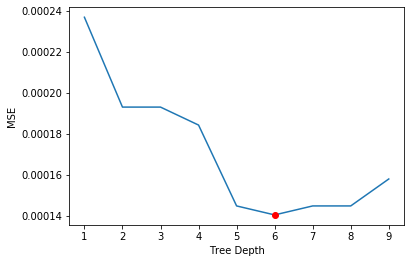

In [7]:
plt.figure()
plt.plot(depthList,xvalMSE)
plt.axis("tight")
plt.xlabel("Tree Depth")
plt.ylabel("MSE")
opt_depth = depthList[np.argmin(xvalMSE)]
plt.plot(opt_depth,np.amin(xvalMSE),"or")

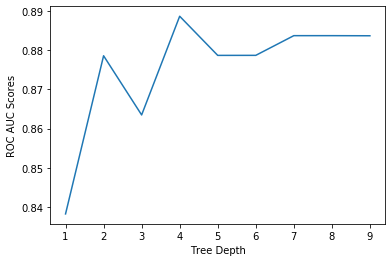

In [8]:
plt.figure()
plt.plot(depthList,score_history)
plt.axis("tight")
plt.xlabel("Tree Depth")
plt.ylabel("ROC AUC Scores")
plt.show()

In [9]:
print("Minimum MSE:",np.amin(xvalMSE))
print("Maximum ROC AUC Score:", np.amax(score_history))

Minimum MSE: 0.00014044573966626582
Maximum ROC AUC Score: 0.8887130245154936


In [10]:
print(accuracy_score(y_test, treePrediction))
print(f1_score(y_test, treePrediction))

0.9993679886237953
0.8085106382978724
